## Recurrent Neural Network

In [1]:
# !pip install tensorflow

In [2]:
# from google.colab import drive
# drive.mount('/content/drive') # This line mounts your Google Drive to the Colab environment.

# from google.colab import files
# files.upload() # This line opens a file picker to upload files from your local machine to Colab.

In [3]:
# Create config directory and move kaggle.json
# Creates the directory structure for Kaggle configuration if it doesn't exist
!mkdir -p /root/.config/kaggle
# Copies the kaggle.json file (assumed to be in the current directory)
# to the Kaggle configuration directory
!cp kaggle.json /root/.config/kaggle/
# Sets read-only permissions for the owner of the kaggle.json file
!chmod 600 /root/.config/kaggle/kaggle.json

In [4]:
# Step 2: Install and import Kaggle API
!pip install -q kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
# Step 3: Authenticate with Kaggle API using kaggle.json file
# This requires the kaggle.json file to be present in /root/.config/kaggle/
api.authenticate()

# Step 4: Define dataset name and download/unzip dataset
dataset_name = 'vaibhavsxn/google-stock-prices-training-and-test-data'
# Download the dataset files to the current directory and unzip them
api.dataset_download_files(dataset_name, path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/vaibhavsxn/google-stock-prices-training-and-test-data


In [5]:
# Importing Libraries
import numpy as np      # For numerical operations, especially with arrays
import pandas as pd     # For data manipulation and analysis, using DataFrames
import matplotlib.pyplot as plt # For creating visualizations (plots and charts)

In [6]:
# Importing training set
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')
# Extract all rows and only the second column (index 1) from dataset_train,
# then convert it to a NumPy array (using .values) for compatibility with ML models
training_set = dataset_train.iloc[:, 1:2].values

In [7]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler
# Min-Max Scaling transforms your feature values so that they fall between a specified range—usually 0 to 1.
# Formula: Xscaled = (X - Xmin) / (Xmax - Xmin)
# Benefits: Makes training more stable & Prevents feature dominance
sc = MinMaxScaler(feature_range = (0, 1))
# This fits the scaler to the training data (learns the min/max) and then transforms the data
training_sc_scaled = sc.fit_transform(training_set)

In [8]:
# Create a data structure with 60 timesteps and 1 output
X_train = []  # List to store input sequences (60 previous stock prices)
y_train = []  # List to store output values (the next stock price)

# Loop through the scaled training data to create sequences
# Starting from index 60 to allow for a 60-timestep lookback
for i in range(60, 1258):
    # Append the previous 60 data points as the input sequence
    X_train.append(training_sc_scaled[i-60:i, 0])
    # Append the current data point as the output value
    y_train.append(training_sc_scaled[i, 0])

# Convert the lists to NumPy arrays, which are required for training
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
# Reshaping the data for the LSTM layer
# LSTM layers in Keras expect input in the format (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [10]:
# Building the RNN

from keras.models import Sequential
from keras.layers import Dense    # Fully connected layer
from keras.layers import Dropout  # Regularization
from keras.layers import LSTM     # Long Short-Term Memory layer

# Initializing the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularization
# units: Number of LSTM units (neurons) in this layer
# return_sequences: True because we will add more LSTM layers later
# input_shape: (timesteps, features) - Keras infers the number of samples
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Adding Dropout to prevent overfitting
# rate: The fraction of the input units to drop
regressor.add(Dropout(0.2))
# Adding the second LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding the third LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding the forth LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Adding the output layer
# units: 1 because we're predicting a single value
regressor.add(Dense(units = 1))

regressor.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Compile and Train
# Compiling the RNN
# optimizer: The optimization algorithm used to update the weights (e.g., 'adam')
# loss: The loss function used to measure the difference between predicted and actual values (e.g., 'mean_squared_error' for regression)
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Training the RNN
# X_train: The input training data
# y_train: The target output values for the training data
# epochs: The number of times the training dataset will be passed forward and backward through the neural network
# batch_size: The number of samples per gradient update
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0910
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0064
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0052
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0052
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0054
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0047
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0053
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0055
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0049
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0042
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0043
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0041
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0034
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0042
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - lo

In [12]:
# Importing test set and real stock prices
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')
# Extract all rows and only the second column (index 1) from dataset_test,
# then convert it to a NumPy array (using .values) for compatibility with ML models
real_stock_price = dataset_test.iloc[:, 1:2].values

In [13]:
# Getting the predicted stock price

# Concatenate the 'Open' column from both training and test datasets
# This is needed to get the previous 60 days for predictions in the test set
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

# Extract the input data for predictions: last 60 days of training + all test data
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

# Reshape the input data to be a 2D array (number of data points, 1 feature)
inputs = inputs.reshape(-1,1)

# Apply the same scaler fitted on the training data to the input data
inputs = sc.transform(inputs)

# Create test sequences (each sequence is 60 previous stock prices)
X_test = []
# Loop through the input data to create sequences for the test set
# The range is from 60 to 80 to create sequences for the 20 test data points
for i in range(60, 80):
    # Append the previous 60 data points as the input sequence for prediction
    X_test.append(inputs[i-60:i, 0])

# Convert the list of test sequences to a NumPy array
X_test = np.array(X_test)

# Reshape X_test to the required 3D format (samples, timesteps, features) for the LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Make predictions using the trained RNN model
predicted_stock_price = regressor.predict(X_test)

# Inverse transform the predictions to get the actual stock prices (undo scaling)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step


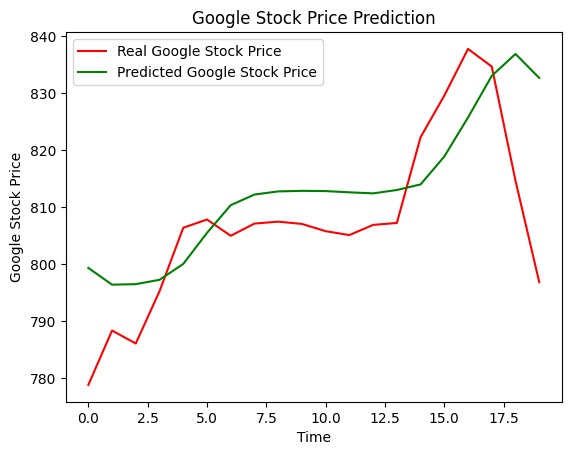

In [14]:
# Visualizaiton
# Plotting the real stock prices
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
# Plotting the predicted stock prices
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Google Stock Price')
# Setting the title of the plot
plt.title('Google Stock Price Prediction')
# Setting the label for the x-axis
plt.xlabel('Time')
# Setting the label for the y-axis
plt.ylabel('Google Stock Price')
# Displaying the legend
plt.legend()
# Showing the plot
plt.show()